In [324]:
import numpy as np
from pytorch_lightning.callbacks import LearningRateMonitor
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from pytorch_lightning.callbacks import ModelSummary
from sklearn.preprocessing import OneHotEncoder
from tensorboardX import SummaryWriter
from sklearn.preprocessing import StandardScaler
from pytorch_lightning.loggers import CSVLogger
import torch
import pandas as pd
import datetime
import torch.nn as nn
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader 
import pytorch_lightning as pl
from datetime import datetime
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torchmetrics import Accuracy

In [325]:
monk1_train = pd.read_csv('data/monks-1.train',header=None,sep=" ")
monk1_test = pd.read_csv('data/monks-1.test',header=None,sep=" ")

In [326]:
monk1_train.drop(0,axis=1,inplace=True)
monk1_train.drop(8,axis=1,inplace=True)

monk1_test.drop(0,axis=1,inplace=True)
monk1_test.drop(8,axis=1,inplace=True)

In [327]:
xtr = monk1_train.iloc[:,1:]
ytr = monk1_train.iloc[:,0]

xts = monk1_test.iloc[:,1:]
yts = monk1_test.iloc[:,0]

In [328]:
type(xtr)

pandas.core.frame.DataFrame

In [329]:
encoder = OneHotEncoder()       
encoder.fit(xtr)
encoder.fit(xts)
xtr = encoder.transform(xtr).toarray()
xts = encoder.transform(xts).toarray()

In [330]:
#scaler = MinMaxScaler()
#xtr = scaler.fit_transform(xtr)
#xts = scaler.fit_transform(xts)

In [331]:
xtr, xvl, ytr, yvl = train_test_split(xtr, ytr, test_size=0.30, shuffle=True, random_state=42)

In [332]:
len(xvl)

38

In [333]:
ytr = ytr.to_numpy()
yvl = yvl.to_numpy()

# Without momentum, fixed epoch and fixed lr

In [334]:
class ClassificationMonk(pl.LightningModule):
    def __init__(self, input_dim, output_dim, hidden1, learning_rate):
        super(ClassificationMonk, self).__init__()
        # First hidden layer
        self.linear1 = nn.Linear(input_dim, hidden1)
        self.act1 = nn.ReLU()
        # Second hidden layer
        self.linear2 = nn.Linear(hidden1, hidden1)
        self.act2 = nn.ReLU()
        # Third hidden layer
        self.linear3 = nn.Linear(hidden1,output_dim)
        self.act3 = nn.Sigmoid()
        self.loss_fun = nn.MSELoss()
        self.dicts = []
        self.learning_rate = learning_rate
        self.apply(self.init_weights)
    
    def init_weights(self,m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    
    def forward(self, X):
        #Input to the first hidden layer
        X = self.linear1(X)
        X = self.act1(X)
        # Second hidden layer
        X = self.linear2(X)
        X = self.act2(X)
        # Third hidden layer
        X = self.linear3(X)
        X = self.act3(X)
        return X

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        X, y = train_batch 
        y_copy = y # Integer y for the accuracy
        X = X.type(torch.float32)
        y = y.type(torch.float32)  
        # forward pass
        y_pred = self.forward(X).squeeze()  
        # accuracy
        accuracy = Accuracy()
        acc = accuracy(y_pred, y_copy)
        # compute loss
        loss = self.loss_fun(y_pred, y)
        self.log_dict({'train_loss': loss, 'train_accuracy': acc}, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, validation_batch, batch_idx):
        X, y = validation_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X).squeeze()        
        # compute metrics 
        accuracy = Accuracy()
        acc = accuracy(y_pred, y)
        loss = self.loss_fun(y_pred, y)
        self.log_dict({'validation_loss': loss, 'validation_accuracy': acc}, prog_bar=True, logger=True)
        return loss
    
    
    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X).squeeze()        
        # compute metrics   
        accuracy = Accuracy()
        acc = accuracy(y_pred, y)
        loss = self.loss_fun(y_pred, y)
        self.log_dict({'test_loss': loss, 'test_accuracy': acc}, on_epoch=True,on_step=False, prog_bar=True, logger=True)
        return loss

In [335]:
hidden1 = 20
max_epochs = 500
lr = 0.05248074602497723 
train_batch_size = 10 
validation_batch_size = 10
test_batch_size = 10

In [336]:
# model instance
input_dim = xtr.shape[1]
model = ClassificationMonk(input_dim=input_dim, output_dim=1, hidden1=hidden1, learning_rate=lr)

In [337]:
class ClassificationMonkDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [338]:
train_loader = DataLoader(dataset = ClassificationMonkDataset(xtr, ytr), batch_size=train_batch_size)
validation_loader = DataLoader(dataset = ClassificationMonkDataset(xvl, yvl), batch_size=validation_batch_size)
test_loader = DataLoader(dataset = ClassificationMonkDataset(xts, yts), batch_size=test_batch_size)

In [339]:
# early stopping
#early_stop_callback = EarlyStopping(monitor="train_loss", min_delta=0.0001, patience=5, verbose=True, mode="min")

In [340]:
trainer = pl.Trainer(accelerator='cpu', devices=1, max_epochs=max_epochs,log_every_n_steps=5,logger=CSVLogger(save_dir="logs/"))  

# for auto lr find
#trainer.tune(model=model, train_dataloaders=train_loader) #for auto_lr_finder

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [341]:
trainer.fit(model=model, train_dataloaders=train_loader,val_dataloaders=validation_loader) 


  | Name     | Type    | Params
-------------------------------------
0 | linear1  | Linear  | 360   
1 | act1     | ReLU    | 0     
2 | linear2  | Linear  | 420   
3 | act2     | ReLU    | 0     
4 | linear3  | Linear  | 21    
5 | act3     | Sigmoid | 0     
6 | loss_fun | MSELoss | 0     
-------------------------------------
801       Trainable params
0         Non-trainable params
801       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/dylan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/dylan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [342]:
#trainer.validate(model=model, dataloaders=validation_loader)

In [343]:
trainer.test(model=model, dataloaders=test_loader)

/Users/dylan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy                 1.0
        test_loss           0.00702882744371891
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.00702882744371891, 'test_accuracy': 1.0}]

In [344]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
#del metrics["step"]
metrics

,validation_loss,validation_accuracy,epoch,step,train_loss,train_accuracy,test_loss,test_accuracy
0,0.254411,0.473684,0,8,NaN,NaN,NaN,NaN
1,NaN,NaN,0,8,0.256904,0.453488,NaN,NaN
2,0.256060,0.473684,1,17,NaN,NaN,NaN,NaN
3,NaN,NaN,1,17,0.251209,0.476744,NaN,NaN
4,0.257382,0.447368,2,26,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
996,0.006925,1.000000,498,4490,NaN,NaN,NaN,NaN
997,NaN,NaN,498,4490,0.000647,1.000000,NaN,NaN
998,0.006911,1.000000,499,4499,NaN,NaN,NaN,NaN
999,NaN,NaN,499,4499,0.000644,1.000000,NaN,NaN


In [345]:
tr_loss = metrics["train_loss"].dropna()
vl_loss = metrics["validation_loss"].dropna()
tr_acc = metrics["train_accuracy"].dropna()
vl_acc = metrics["validation_accuracy"].dropna()

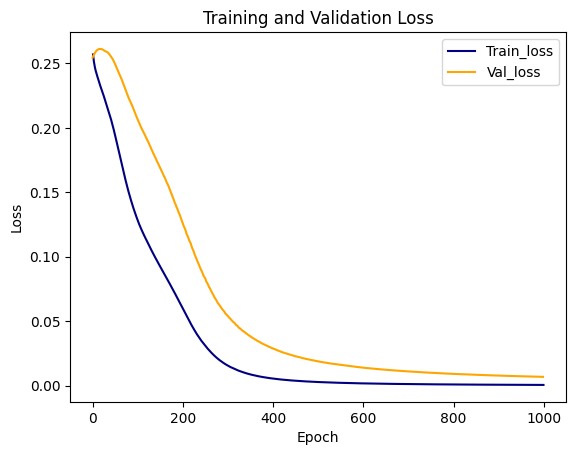

In [346]:
plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")



plt.plot(tr_loss,label="Train_loss",color="navy")
plt.plot(vl_loss,label="Val_loss",color="orange")

plt.legend(loc='best')
plt.show()

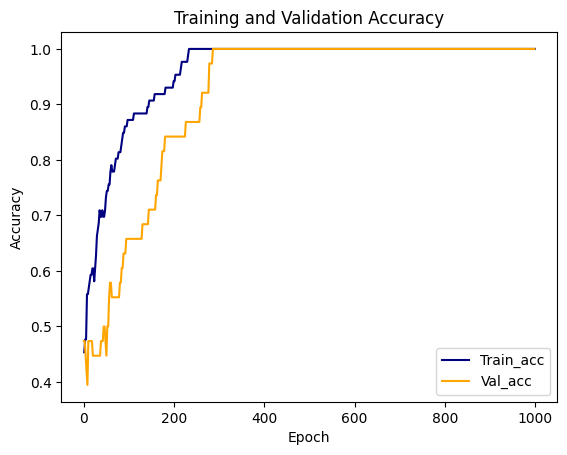

In [347]:
plt.title('Training and Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")



plt.plot(tr_acc,label="Train_acc",color="navy")
plt.plot(vl_acc,label="Val_acc",color="orange")

plt.legend(loc='best')
plt.show()

# Inserting Momentum

In [348]:
class ClassificationMonk(pl.LightningModule):
    def __init__(self, input_dim, output_dim, hidden1, learning_rate):
        super(ClassificationMonk, self).__init__()
        # First hidden layer
        self.linear1 = nn.Linear(input_dim, hidden1)
        self.act1 = nn.ReLU()
        # Second hidden layer
        self.linear2 = nn.Linear(hidden1, hidden1)
        self.act2 = nn.ReLU()
        # Third hidden layer
        self.linear3 = nn.Linear(hidden1,output_dim)
        self.act3 = nn.Sigmoid()
        self.loss_fun = nn.MSELoss()
        self.dicts = []
        self.learning_rate = learning_rate
        self.apply(self.init_weights)
    
    def init_weights(self,m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    
    def forward(self, X):
        #Input to the first hidden layer
        X = self.linear1(X)
        X = self.act1(X)
        # Second hidden layer
        X = self.linear2(X)
        X = self.act2(X)
        # Third hidden layer
        X = self.linear3(X)
        X = self.act3(X)
        return X

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate,momentum=0.9)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        X, y = train_batch 
        y_copy = y # Integer y for the accuracy
        X = X.type(torch.float32)
        y = y.type(torch.float32)  
        # forward pass
        y_pred = self.forward(X).squeeze()  
        # accuracy
        accuracy = Accuracy()
        acc = accuracy(y_pred, y_copy)
        # compute loss
        loss = self.loss_fun(y_pred, y)
        self.log_dict({'train_loss': loss, 'train_accuracy': acc}, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, validation_batch, batch_idx):
        X, y = validation_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X).squeeze()        
        # compute metrics 
        accuracy = Accuracy()
        acc = accuracy(y_pred, y)
        loss = self.loss_fun(y_pred, y)
        self.log_dict({'validation_loss': loss, 'validation_accuracy': acc}, prog_bar=True, logger=True)
        return loss
    
    
    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X).squeeze()        
        # compute metrics   
        accuracy = Accuracy()
        acc = accuracy(y_pred, y)
        loss = self.loss_fun(y_pred, y)
        self.log_dict({'test_loss': loss, 'test_accuracy': acc}, on_epoch=True,on_step=False, prog_bar=True, logger=True)
        return loss

In [349]:
hidden1 = 20
max_epochs = 500
lr = 0.05248074602497723 
train_batch_size = 10 
validation_batch_size = 10
test_batch_size = 10

In [350]:
# model instance
input_dim = xtr.shape[1]
model = ClassificationMonk(input_dim=input_dim, output_dim=1, hidden1=hidden1, learning_rate=lr)

In [351]:
trainer = pl.Trainer(accelerator='cpu', devices=1, max_epochs=max_epochs,log_every_n_steps=5,logger=CSVLogger(save_dir="logs/"))  

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [352]:
trainer.fit(model=model, train_dataloaders=train_loader,val_dataloaders=validation_loader) 


  | Name     | Type    | Params
-------------------------------------
0 | linear1  | Linear  | 360   
1 | act1     | ReLU    | 0     
2 | linear2  | Linear  | 420   
3 | act2     | ReLU    | 0     
4 | linear3  | Linear  | 21    
5 | act3     | Sigmoid | 0     
6 | loss_fun | MSELoss | 0     
-------------------------------------
801       Trainable params
0         Non-trainable params
801       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/dylan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/dylan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [353]:
trainer.test(model=model, dataloaders=test_loader)

/Users/dylan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9976851940155029
        test_loss          0.006799591705203056
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.006799591705203056, 'test_accuracy': 0.9976851940155029}]

In [354]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
#del metrics["step"]
#metrics

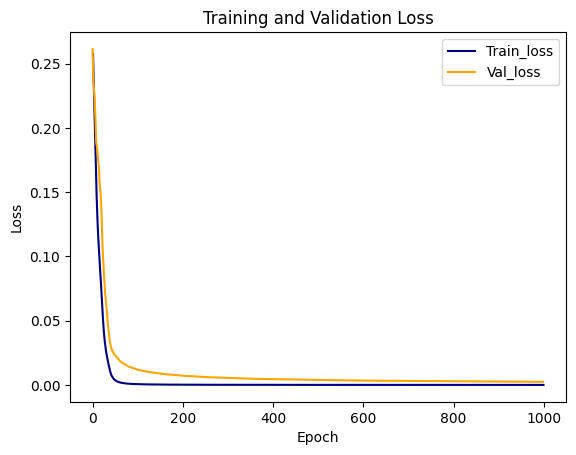

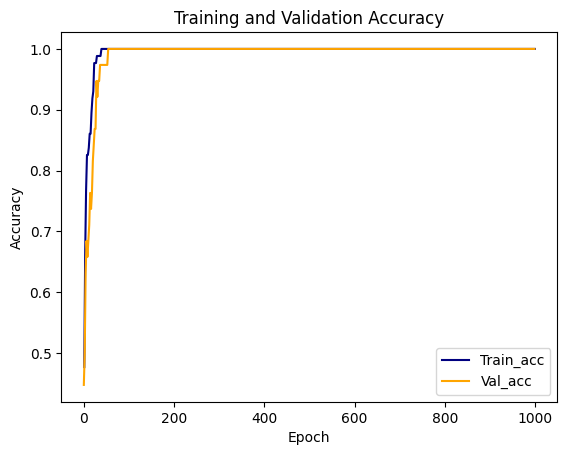

In [355]:
tr_loss = metrics["train_loss"].dropna()
vl_loss = metrics["validation_loss"].dropna()
tr_acc = metrics["train_accuracy"].dropna()
vl_acc = metrics["validation_accuracy"].dropna()

plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")



plt.plot(tr_loss,label="Train_loss",color="navy")
plt.plot(vl_loss,label="Val_loss",color="orange")

plt.legend(loc='best')
plt.show()

plt.title('Training and Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")



plt.plot(tr_acc,label="Train_acc",color="navy")
plt.plot(vl_acc,label="Val_acc",color="orange")

plt.legend(loc='best')
plt.show()

# Inserting early stopping 

In [368]:
class ClassificationMonk(pl.LightningModule):
    def __init__(self, input_dim, output_dim, hidden1, learning_rate):
        super(ClassificationMonk, self).__init__()
        # First hidden layer
        self.linear1 = nn.Linear(input_dim, hidden1)
        self.act1 = nn.ReLU()
        # Second hidden layer
        self.linear2 = nn.Linear(hidden1, hidden1)
        self.act2 = nn.ReLU()
        # Third hidden layer
        self.linear3 = nn.Linear(hidden1,output_dim)
        self.act3 = nn.Sigmoid()
        self.loss_fun = nn.MSELoss()
        self.dicts = []
        self.learning_rate = learning_rate
        self.apply(self.init_weights)
    
    def init_weights(self,m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
    
    def forward(self, X):
        #Input to the first hidden layer
        X = self.linear1(X)
        X = self.act1(X)
        # Second hidden layer
        X = self.linear2(X)
        X = self.act2(X)
        # Third hidden layer
        X = self.linear3(X)
        X = self.act3(X)
        return X

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate,momentum=0.9)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        X, y = train_batch 
        y_copy = y # Integer y for the accuracy
        X = X.type(torch.float32)
        y = y.type(torch.float32)  
        # forward pass
        y_pred = self.forward(X).squeeze()  
        # accuracy
        accuracy = Accuracy()
        acc = accuracy(y_pred, y_copy)
        # compute loss
        loss = self.loss_fun(y_pred, y)
        self.log_dict({'train_loss': loss, 'train_accuracy': acc}, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, validation_batch, batch_idx):
        X, y = validation_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X).squeeze()        
        # compute metrics 
        accuracy = Accuracy()
        acc = accuracy(y_pred, y)
        loss = self.loss_fun(y_pred, y)
        self.log_dict({'validation_loss': loss, 'validation_accuracy': acc}, prog_bar=True, logger=True)
        return loss
    
    
    def test_step(self, test_batch, batch_idx):
        X, y = test_batch
        X = X.type(torch.float32)
        # forward pass
        y_pred = self.forward(X).squeeze()        
        # compute metrics   
        accuracy = Accuracy()
        acc = accuracy(y_pred, y)
        loss = self.loss_fun(y_pred, y)
        self.log_dict({'test_loss': loss, 'test_accuracy': acc}, on_epoch=True,on_step=False, prog_bar=True, logger=True)
        return loss
    
    
hidden1 = 20
max_epochs = 500
lr = 0.05248074602497723 
train_batch_size = 10 
validation_batch_size = 10
test_batch_size = 10


# model instance
input_dim = xtr.shape[1]
model = ClassificationMonk(input_dim=input_dim, output_dim=1, hidden1=hidden1, learning_rate=lr)

# early stopping
early_stop_callback = EarlyStopping(monitor="train_loss", min_delta=0.0001, patience=40, verbose=True, mode="min")

trainer = pl.Trainer(accelerator='cpu', devices=1,callbacks=[early_stop_callback], max_epochs=max_epochs,logger=CSVLogger(save_dir="logs/"))  
trainer.fit(model=model, train_dataloaders=train_loader,val_dataloaders=validation_loader) 




GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type    | Params
-------------------------------------
0 | linear1  | Linear  | 360   
1 | act1     | ReLU    | 0     
2 | linear2  | Linear  | 420   
3 | act2     | ReLU    | 0     
4 | linear3  | Linear  | 21    
5 | act3     | Sigmoid | 0     
6 | loss_fun | MSELoss | 0     
-------------------------------------
801       Trainable params
0         Non-trainable params
801       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/dylan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/dylan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/dylan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1558: PossibleUserWarning: The number of training

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved. New best score: 0.255


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.022 >= min_delta = 0.0001. New best score: 0.234


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.018 >= min_delta = 0.0001. New best score: 0.216


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.019 >= min_delta = 0.0001. New best score: 0.197


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.020 >= min_delta = 0.0001. New best score: 0.176


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.019 >= min_delta = 0.0001. New best score: 0.157


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.017 >= min_delta = 0.0001. New best score: 0.140


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.014 >= min_delta = 0.0001. New best score: 0.126


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.012 >= min_delta = 0.0001. New best score: 0.114


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.009 >= min_delta = 0.0001. New best score: 0.105


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.098


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.090


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.083


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.075


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.068


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.061


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.053


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.046


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.038


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.031


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.026


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.022


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.019


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.016


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.014


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.012


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.011


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.010


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.009


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.007


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.007


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.006


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.005


Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.004


Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.001


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.001


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.001


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.001


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.000


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric train_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.000


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [369]:
trainer.test(model=model, dataloaders=test_loader)

/Users/dylan/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9467592835426331
        test_loss           0.03456759825348854
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.03456759825348854, 'test_accuracy': 0.9467592835426331}]

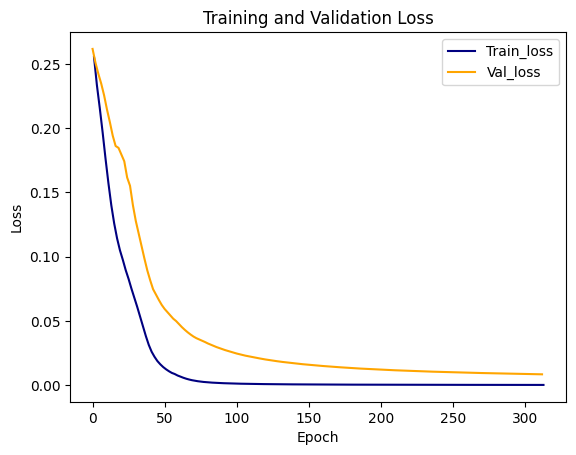

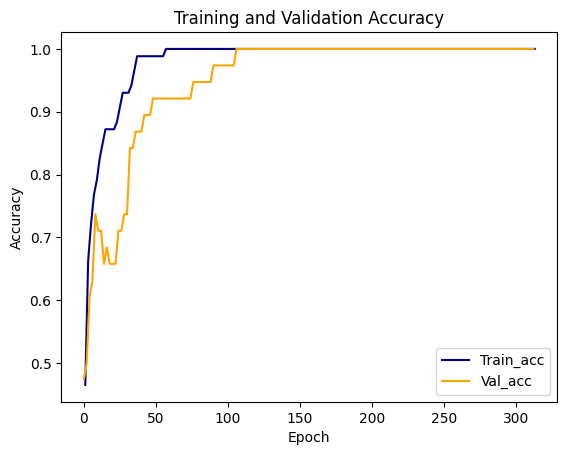

In [370]:

metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

tr_loss = metrics["train_loss"].dropna()
vl_loss = metrics["validation_loss"].dropna()
tr_acc = metrics["train_accuracy"].dropna()
vl_acc = metrics["validation_accuracy"].dropna()

plt.title('Training and Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")



plt.plot(tr_loss,label="Train_loss",color="navy")
plt.plot(vl_loss,label="Val_loss",color="orange")

plt.legend(loc='best')
plt.show()

plt.title('Training and Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")



plt.plot(tr_acc,label="Train_acc",color="navy")
plt.plot(vl_acc,label="Val_acc",color="orange")

plt.legend(loc='best')
plt.show()